In [2]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
     ---------                             75.9/300.9 MB 677.7 kB/s eta 0:05:32


ERROR: Exception:
Traceback (most recent call last):
  File "C:\ProgramData\miniconda3\lib\site-packages\pip\_vendor\urllib3\response.py", line 437, in _error_catcher
    yield
  File "C:\ProgramData\miniconda3\lib\site-packages\pip\_vendor\urllib3\response.py", line 560, in read
    data = self._fp_read(amt) if not fp_closed else b""
  File "C:\ProgramData\miniconda3\lib\site-packages\pip\_vendor\urllib3\response.py", line 526, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
  File "C:\ProgramData\miniconda3\lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 90, in read
    data = self.__fp.read(amt)
  File "C:\ProgramData\miniconda3\lib\http\client.py", line 465, in read
    s = self.fp.read(amt)
  File "C:\ProgramData\miniconda3\lib\socket.py", line 705, in readinto
    return self._sock.recv_into(b)
  File "C:\ProgramData\miniconda3\lib\ssl.py", line 1274, in recv_into
    return self.read(nbytes, buffer)
  File "C:\ProgramData\minico

In [3]:
import numpy as np
import json
from matplotlib import pyplot as plt, cm
import tensorflow as tf
import numpy as np

import os
import traceback

from tensorflow.keras.applications.resnet50 import (ResNet50,
                                                    preprocess_input as resnet50_preprocess_input,
                                                    decode_predictions as resnet50_decode_predictions)
from tensorflow.keras.applications.vgg16 import (VGG16,
                                                    preprocess_input as vgg16_preprocess_input,
                                                    decode_predictions as vgg16_decode_predictions)
from tensorflow.keras.applications.vgg19 import (VGG19,
                                                    preprocess_input as vgg19_preprocess_input,
                                                    decode_predictions as vgg19_decode_predictions)
from tensorflow.keras.applications.inception_v3 import (InceptionV3,
                                                    preprocess_input as inception_v3_preprocess_input,
                                                    decode_predictions as inception_v3_decode_predictions)
from tensorflow.keras.applications.xception import (Xception,
                                                    preprocess_input as xception_preprocess_input,
                                                    decode_predictions as xception_decode_predictions)


from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow.keras.activations as tf_act

from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.scorecam import Scorecam
        
import cv2 as cv2
from inpaint import inpaint

from skimage.restoration import inpaint as sk_inpaint

ModuleNotFoundError: No module named 'tensorflow'

In [4]:
# tf.config.list_physical_devices('GPU')
# tf.config.set_visible_devices
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [5]:
ROOT_DIR = os.getcwd()
CURR_DIR = os.getcwd()

def cnv_lst_arr(lst):
    ''' Convert list object to array. '''
    arr = np.array(lst)
    return arr

def reset_dir():
    ''' Change the directory to root directory of project. '''
    os.chdir(ROOT_DIR)
    CURR_DIR = os.getcwd()

def change_dir(dir):
    '''
    Change the directory to specified directory.

    Args:
        dir: The directory where to set the cwd
    '''
    os.chdir(dir)
    CURR_DIR = os.getcwd()

In [6]:
class inpaint_defense:
    def __init__(self, model=ResNet50(), activation_fn=tf_act.linear, technique = 'base', bin_thresh=0.5, dset_type='adversarial'):
        '''
        Args:
            model: The pre-trained model for making predictions
            batch_size: The number of images in the dataset
            classlabel: The class label for 1000 classes
            clean_images: The batch of images without any adversarial patch [?, 224, 224, 3]
            clean_predictions: The array of predictions for images without patch [?, class_index, class, confidence]
            clean_class_lbls: The array of class index the clean image belongs to
            ground_truths: The array of actual class the images belongs to 
            adv_images: The batch of adverasrial images [?, 224, 224, 3]
            adv_predictions: The array of predictions for the adversarial image [?, class_index, object class, confidence]
            adv_class_lbls: The index of each class the image with adversarial patch belongs to
            new_predictions: The array of predictions after inpainting the adversarial image [?, class_index, object class, confidence]
            new_class_lbls: The array of class index the inpainted image belongs to
            cams: The batch of cam filter obtained for each image [?, 224, 224]
            patch_mask: The patch mask generated using a threshold value (0.5) [?, 224, 224]
            inpaint_images: The batch of images obtained after applying inpainting [?, 224, 224, 3]
            activation_fn: The activation function used for generating heatmap of salient features
            technique: The technique being used for pipeline
            bin_thresh: Threshold for generating binary mask
            dset_type: Determine if its an 'adversarial' or 'benign' dataset
        '''
        self.model = model
        self.batch_size = 0
        self.clean_images = []
        self.ground_truths = []
        self.clean_class_lbls = []
        self.adv_images = []
        self.clean_predictions = []
        self.adv_predictions = []
        self.new_predictions = []
        self.adv_class_lbls = []
        self.new_class_lbls = []
        self.cams = []
        self.patch_masks = []
        self.inpaint_images = []
        self.activ_fn = activation_fn
        self.technique = technique
        self.bin_thresh = bin_thresh
        self.dset_type = dset_type
        
        # Download the json file of list of classes in imagenet with index
        if os.path.isfile('imagenet_class_index.json') == False:
            os.system("wget \"https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json\"")

        CLASS_INDEX = json.load(open("imagenet_class_index.json"))
        
        classlabel  = []
        for i_dict in range(len(CLASS_INDEX)):
            classlabel.append(CLASS_INDEX[str(i_dict)][1])
        self.classlabel = classlabel
        self.CLASS_INDEX = CLASS_INDEX
    
    def set_params(activation_fn=tf_act.linear, technique = 'base',
                   bin_thresh=0.5, dset_type='adversarial',
                   cnvt_ADV2BGN=False):
        '''
        Set the parameters for the class object
        Args:
            activation_fn: The activation function used for generating heatmap of salient features
            technique: The technique being used for pipeline
            bin_thresh: Threshold for generating binary mask
            dset_type: Determine if its an 'adversarial' or 'benign' dataset
            cnvt_ADV2BGN: boolean variable that indicate to replace adversarial data with clean data 
        '''
        self.activation_fn = activation_fn
        self.technique = technique
        self.bin_thresh = bin_thresh
        self.dset_type = dset_type
        if self.inpaint_images != []:
            del self.inpaint_images
            self.inpaint_images = []

        if cnvt_ADV2BGN == True:
            del self.adv_images
            del self.adv_predictions
            del self.adv_class_lbls
            self.adv_images = self.clean_images.copy()
            self.adv_predictions = self.clean_predictions.copy()
            self.adv_class_lbls = self.new_class_lbls.copy()
            

    def load_dataset(self, directory, no_of_classes=100, img_per_class=2, show_plot=False):
        '''
        Load the dataset from given directory.

        Args:
            directory: A directory that contains folders in format:
                                    ---directory
                                        ---adv_images
                                            ---class1
                                                ---image1.jpg
                                                ---image2.jpg
                                                    ...
                                            ---class2
                                                ---image1.jpg
                                                ---image2.jpg
                                                    ...
                                                ...
                                        ---clean_images
                                            ---class1
                                                ---image1.jpg
                                                ---image2.jpg
                                                    ...
                                            ---class2
                                                ---image1.jpg
                                                ---image2.jpg
                                                    ...
                                                ...
                        Make sure the adversarial image folder start with 'adv' and clean image folder starts with 'clean'
            img_per_class: The number of images to display for each class (defaults to 2)
            show_plot: a boolean variable to determine whether to display the plots of images(default, True)
        '''
        clean_img_count = 0
        adv_img_count = 0
        try:
            img_height = 224
            img_width = 224
            
            change_dir(directory)
            for folder in os.listdir():
                data_directory = os.path.join(os.getcwd(), folder)
                images = image_dataset_from_directory(
                    data_directory,
                    seed=42, 
                    image_size=(img_height, img_width),
                    batch_size=img_per_class, # The dataset will yield individual samples.
                    color_mode='rgb')

                if folder.startswith('adv'):
                    for img, labels in images.take(no_of_classes):
                        [self.process_image(images, image, lbl, 'adv', show_plot) for image, lbl in zip(img, labels)]

                if folder.startswith('clean'):
                    for img, labels in images.take(no_of_classes):
                        [self.process_image(images, image, lbl, 'clean', show_plot) for image, lbl in zip(img, labels)]
            
            if self.batch_size%2 == 0:
                self.batch_size = int(self.batch_size/2)
            # Convert all the list to array elements
            self.clean_images = cnv_lst_arr(self.clean_images)
            self.clean_predictions = cnv_lst_arr(self.clean_predictions)
            self.clean_class_lbls = cnv_lst_arr(self.clean_class_lbls)
            self.adv_images = cnv_lst_arr(self.adv_images)
            self.adv_predictions = cnv_lst_arr(self.adv_predictions)
            self.adv_class_lbls = cnv_lst_arr(self.adv_class_lbls)
            self.ground_truths = cnv_lst_arr(self.ground_truths)
            reset_dir()
            
        except Exception as e:
            print(traceback.format_exc())
            print(e)
            reset_dir()
    
    def process_image(self, image_gen, image, label, data_type, plot=False):
        
        img = img_to_array(image).astype(np.uint8)
        if data_type == 'adv':
            self.adv_images.append(img.copy())
            img = np.expand_dims(img, axis=0)

            preprocess_fn = self.preprocess_input_fn()
            decode_fn = self.decode_predictionst_fn()

            tmp_img = preprocess_fn(img.copy())
            img_pred = self.model.predict(tmp_img)
            prediction = decode_fn(img_pred, top=1)
            class_lbl = self.classlabel.index(prediction[0][0][1])

            self.adv_predictions.append(prediction[0][0])
            self.adv_class_lbls.append(class_lbl)
        else:
            self.clean_images.append(img.copy())
            img = np.expand_dims(img, axis=0)

            preprocess_fn = self.preprocess_input_fn()
            decode_fn = self.decode_predictionst_fn()

            tmp_img = preprocess_fn(img.copy())
            img_pred = self.model.predict(tmp_img)
            prediction = decode_fn(img_pred, top=1)
            class_lbl = self.classlabel.index(prediction[0][0][1])

            class_list = [itm for val in self.CLASS_INDEX.values() for itm in val]
            ind = int(class_list.index(image_gen.class_names[label]) / 2)

            self.ground_truths.append((self.classlabel[ind]))
            self.clean_predictions.append(prediction[0][0])
            self.clean_class_lbls.append(class_lbl)
        self.batch_size += 1
        if plot == True:
            self.plot_images(img)

    def preprocess_input_fn(self):
        if self.model.name == 'resnet50':
            return resnet50_preprocess_input
        if self.model.name == 'vgg16':
            return vgg16_preprocess_input
        if self.model.name == 'vgg19':
            return vgg19_preprocess_input
        if self.model.name == 'inception_v3':
            return inception_v3_preprocess_input
        if self.model.name == 'xception':
            return xception_preprocess_input
        return None

    def decode_predictionst_fn(self):
        if self.model.name == 'resnet50':
            return resnet50_decode_predictions
        if self.model.name == 'vgg16':
            return vgg16_decode_predictions
        if self.model.name == 'vgg19':
            return vgg19_decode_predictions
        if self.model.name == 'inception_v3':
            return rinception_v3_decode_predictions
        if self.model.name == 'xception':
            return xception_decode_predictions
        return None


    def grad_plot(self, cam, title, heatmap, index):
        '''
        Plot a graph of saliency feature generate through gradCAM.
        
        Args:
            cam: The gradcam object which generates the heatmap
            title: The title of the saliency plot
            heatmap: The heatmap that we generated using gradcam object
            index: The index of the saliency plot for respective image
        '''
        print(title)
        plt.title(title, fontsize=16)
        plt.imshow(np.uint8(self.adv_images[index]))
        plt.imshow(heatmap, cmap='jet', alpha=0.5) # overlay
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    def apply_cam(self, mini_batch, step, show_plot=False):
        '''
        Generates the saliency map of the given batch of images using gradient CAM technique.

        Args:
            show_plot: a boolean variable to determine whether to display the saliency map for each image(default, True)
        '''
        # When the softmax activation function is applied to the last layer of model,
        # it may obstruct generating the attention images, so you should replace the function to a linear activation function.

        def model_modifier_function(cloned_model):
            cloned_model.layers[-1].activation = self.activ_fn

        # And then, you MUST create Score instance or define score function that returns target scores.
        # Here, they return the score values corresponding to images.

        score = CategoricalScore(self.adv_class_lbls[mini_batch : step].tolist())

        image_titles = self.adv_predictions[mini_batch : step].copy()

        # # Create Gradcam object
        # gradcam = Gradcam(self.model, model_modifier=model_modifier_function, clone=True)
        # # Generate heatmap with GradCAM
        # cam = gradcam(score, (np.float32(self.adv_images)).copy(), penultimate_layer=-1)

        # Create Scorecam object
        scorecam = Scorecam(self.model, model_modifier=model_modifier_function)
        # Generate heatmap with Faster-ScoreCAM
        cam = scorecam(score, (np.float32(self.adv_images[mini_batch : step])).copy(), penultimate_layer=-1, max_N=10)

        for i, title in enumerate(image_titles):
            heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)

            if show_plot == True:
                self.grad_plot(cam, title, heatmap, i)

            self.cams.append(cam[i].copy())

    def mask_plot(self, img):
        '''
        Function that plots the mask generated for the image.

        Args:
            img: The mask image to print
        '''
        plt.imshow(np.uint8(img), cmap='gray')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    def gen_mask(self, show_plot=False):
        ''' Generates a binary mask from saliency map obtained for every image in the given batch.'''

        for ind in range(self.cams.shape[0]):

            temp_cam = self.cams[ind].copy()        

            binary_patch_mask = []
            binary_patch_mask = np.where(temp_cam >= self.bin_thresh, 1., 0.) # 1. - (temp_cam.mean())

            self.patch_masks.append(np.array(binary_patch_mask))

            if show_plot == True:
                self.mask_plot(binary_patch_mask)

        self.patch_masks = cnv_lst_arr(self.patch_masks)

    def apply_inpaint(self, show_plot=False):
        '''
        Applies inpainting technique toremove adversarial patch from the images in the given batch.
        Also gives a plot of images obtained after inpainting along with class predictions

        Args:
            show_plot: a boolean variable to determine whether to show plot of new prediction obtained after applying inpainting technique(default, True)
        '''
        for ind in range(self.adv_images.shape[0]):

            inpaint_img = (self.adv_images[ind]).copy()

            src_img = inpaint_img
            img = inpaint_img
            mask = self.patch_masks[ind]

            if self.technique == 'base':
#                 print('Base Inpainting')
                inpaint_img = inpaint(src_img, img, mask)
            
            elif self.technique == 'adaptive_hist':
#                 print('Adaptive Histogram')
                inpaint_img = inpaint(src_img, img, mask)
                
                # Convert the RGB image to LAB color space
                image_lab = cv2.cvtColor(inpaint_img, cv2.COLOR_RGB2LAB)
                
                # Extract the L channel (luminance) from LAB
                l_channel = image_lab[:, :, 0]
                
                # Apply Adaptive Histogram Equalization
                clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
                l_channel_equalized = clahe.apply(l_channel)
                
                # Replace the equalized L channel in LAB
                image_lab[:, :, 0] = l_channel_equalized
                
                # Convert the LAB image back to RGB
                image_equalized = cv2.cvtColor(image_lab, cv2.COLOR_LAB2RGB)
                inpaint_img = image_equalized.copy()
        
            elif self.technique == 'adaptive_hist_biharmonic_inpaint':
#                 print('adaptive_hist+biharmonic_inpaint')
                inpaint_img = sk_inpaint.inpaint_biharmonic(src_img, mask, multichannel=True)
                inpaint_img = np.uint8(inpaint_img * 255)
                
                # Convert the RGB image to LAB color space
                image_lab = cv2.cvtColor(inpaint_img, cv2.COLOR_RGB2LAB)
                
                # Extract the L channel (luminance) from LAB
                l_channel = image_lab[:, :, 0]
                
                # Apply Adaptive Histogram Equalization
                clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
                l_channel_equalized = clahe.apply(l_channel)
                
                # Replace the equalized L channel in LAB
                image_lab[:, :, 0] = l_channel_equalized
                
                # Convert the LAB image back to RGB
                image_equalized = cv2.cvtColor(image_lab, cv2.COLOR_LAB2RGB)
                inpaint_img = image_equalized.copy()
            
            elif self.technique == 'Navier_Stokes':
                inpaint_img = cv2.inpaint(src_img, mask, 3, cv.INPAINT_NS)
            
            elif self.technique == 'FSR_BEST':
                mask = cv2.bitwise_not(mask)
                inpaint_img = cv2.xphoto.inpaint(src_img, mask, 3, cv.INPAINT_FSR_BEST)
            
            elif self.technique == 'FSR_FAST':
                mask = cv2.bitwise_not(mask)
                inpaint_img = cv2.xphoto.inpaint(src_img, mask, 3, cv.INPAINT_FSR_FAST)
            
                
            self.inpaint_images.append(inpaint_img)

            inpaint_img = np.expand_dims(inpaint_img.copy(), axis=0)

            preprocess_fn = self.preprocess_input_fn()
            decode_fn = self.decode_predictionst_fn()
                    
            # Find new predictions after inpainting
            tmp_img = preprocess_fn(inpaint_img.copy())
            img_pred = self.model.predict(tmp_img)
            prediction = decode_fn(img_pred, top=1)
            class_lbl = self.classlabel.index(prediction[0][0][1])

            self.new_predictions.append(prediction[0][0])
            self.new_class_lbls.append(class_lbl)

            if show_plot == True:
                self.plot_images(inpaint_img)

        # Convert all the list to array elements
        self.inpaint_images = cnv_lst_arr(self.inpaint_images)
        self.new_predictions = cnv_lst_arr(self.new_predictions)
        self.new_class_lbls = cnv_lst_arr(self.new_class_lbls)


    def plot_images(self, img):
        '''
        Plot the image with title as the prediction class, confidence and its class label.

        Args:
            img: The imaeg to be plotted [1, 224, 224, 3]
        '''
        # Find new predictions after inpainting
        tmp_img = preprocess_input(img.copy())
        img_pred = self.model.predict(tmp_img)
        prediction = decode_predictions(img_pred, top=1)
        class_lbl = self.classlabel.index(prediction[0][0][1])

        # Rendering
        plt.figure(figsize=(3, 4))
        plt.title(f'Prediction: {prediction[0][0][1]}({prediction[0][0][2]:1.3})\nLabel: {class_lbl}')
        plt.imshow(np.uint8(img[0]))
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    def generate_inpaint(self, step=10, grad_flag=False, mask_flag=False, inpaint_flag=False):
        '''
        A function that performs the given tasks in sequential order. 

        Args:
            grad_plot: Indicates if we want to display the plot of gradient cam
            mask_flag: Indicates if we want to display the plot of mask obtained
            inpaint_flag: Indicates if we want to display the plot of inapint images
        '''
        for mini_batch in range(0, self.batch_size, step):            
            # After loading od data is done, generate its saliency map using grad CAM technique
            self.apply_cam(mini_batch, mini_batch+step, show_plot=grad_flag)
        self.cams = cnv_lst_arr(self.cams)
        
        # genearate a mask by setting a threshold value 
        self.gen_mask(show_plot=mask_flag)

        # Apply inpainting technique and get predictions for class
        self.apply_inpaint(show_plot=inpaint_flag)

    def plot_data(self, index):
        '''
        Plots the graph of following:
            1. Original image
            2. Its heatmap generated using Scorecam
            3. The binary mask generated from the heatmap
            4. The final image after applying inpainting technique

        Args:
            index: The index of the image to print the plots
        '''
        if index < self.batch_size:
            fig, axes = plt.subplots(1, 5, figsize=(12, 7))
            fig.tight_layout()

            axes[0].imshow(self.clean_images[index])
            axes[0].set_title(f'Clean Prediction\n{self.clean_predictions[index][1]}({self.clean_predictions[index][2].astype(np.float32):1.3f})\nLabel: {self.clean_class_lbls[index]}')
            axes[0].axis('off')

            axes[1].imshow(self.adv_images[index])
            axes[1].set_title(f'Adv Prediction\n{self.adv_predictions[index][1]}({self.adv_predictions[index][2].astype(np.float32):1.3f})\nLabel: {self.adv_class_lbls[index]}')
            axes[1].axis('off')

            axes[2].imshow(self.cams[index])
            axes[2].set_title('Heatmap of\nsalient feature')
            axes[2].axis('off')

            axes[3].imshow(self.patch_masks[index], cmap='gray')
            axes[3].set_title('Binary mask\nfor inpainting')
            axes[3].axis('off')

            axes[4].imshow(self.inpaint_images[index])
            axes[4].set_title(f'Inpaint Prediction\n{self.new_predictions[index][1]}({self.new_predictions[index][2].astype(np.float32):1.3f})\nLabel: {self.new_class_lbls[index]}')
            axes[4].axis('off')
            plt.show()

    def defense_accuracy(self):
        '''
        Calculate the following accuracies:
            1. Clean accuracy of the model
            2. Misclassification accuracy of the patch
            3. Inpainting accuracy after applying diffusion technique
        '''
        correct_clean = 0
        correct_adv = 0
        correct_new = 0
        n_success = 0
        n_samples = self.batch_size
        thresh = str(self.bin_thresh).split('.')[1]
        
        filename = f"{self.dset_type}_output_{self.activ_fn.__name__}_{self.technique}_mask_{thresh}.txt"

        if n_samples != 0:
            for index in range(self.batch_size):
                correct_clean += self.ground_truths[index] == self.clean_predictions[:, 1][index]

                correct_adv += self.ground_truths[index] == self.adv_predictions[:, 1][index]

                correct_new += self.ground_truths[index] == self.new_predictions[:, 1][index]

            clean_accuracy = 100 * (correct_clean / n_samples)
            misclassification_accuracy = 100 * (1 - correct_adv / n_samples)
            inpaint_accuracy = 100*(correct_new / n_samples)

            print(f'Clean accuracy: {clean_accuracy:>0.2f}%')
            print(f'Patch success accuracy: {misclassification_accuracy:>0.2f}%')
            print(f'Inpainting Accuracy: {inpaint_accuracy:>0.2f}%')
            
            with open(filename, 'w')as f:
                # f.write(f'Batch size: {self.batch_size}\n')
                f.write(f'Total Images: {self.adv_images.shape[0]}\n')
                f.write(f'Binary Threshold: {self.bin_thresh}\n')
                f.write(f'Activation Fn: {self.activ_fn.__name__}\n')
                f.write(f'Technique: : {self.technique}\n\n')
                f.write(f'Clean Accuracy: {clean_accuracy:>0.2f}%\n')
                f.write(f'Patch Success Rate: {misclassification_accuracy:>0.2f}%\n')
                f.write(f'Inpainting Accuracy: {inpaint_accuracy:>0.2f}%\n')
        else:
            print('There are no samples in the dataset to calculate the accuracy')
            with open(filename, 'w') as f:
                f.write('There are no samples in the dataset to calculate the accuracy.\n')


In [7]:
ROOT_DIR

'/home/manjunathjoshi/202211050/minor_project'

In [ ]:
os.chdir(ROOT_DIR)

id_test = inpaint_defense(activation_fn=tf_act.relu)
id_test.load_dataset('test_data', img_per_class=100)

# Test data

#### base inpainting

Found 2 files belonging to 2 classes.
Found 2 files belonging to 2 classes.


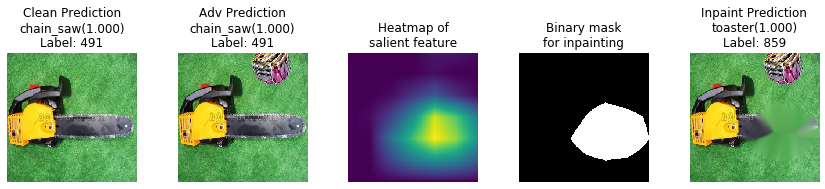

Clean accuracy: 100.00%
Patch success accuracy: 50.00%
Inpainting Accuracy: 50.00%


In [8]:
id_test.generate_inpaint()

# for i in range(id_test.batch_size):
#     id_test.plot_data(i)
id_test.plot_data(1)

id_test.defense_accuracy()

#### adaptive_hist

Found 2 files belonging to 2 classes.
Found 2 files belonging to 2 classes.


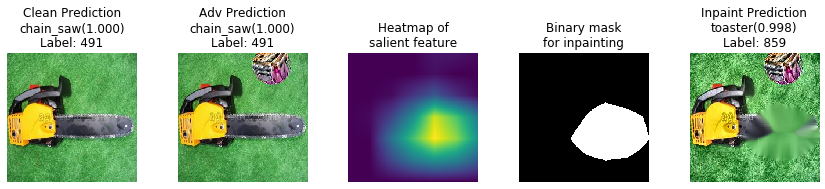

Clean accuracy: 100.00%
Patch success accuracy: 50.00%
Inpainting Accuracy: 0.00%


In [9]:
id_test.set_params(activation_fntf_act.relu, technique='adaptive_hist', bin_thresh=0.7)
id_test.generate_inpaint()

# for i in range(id_test.batch_size):
#     id_test.plot_data(i)
id_test.plot_data(1)

id_test.defense_accuracy()

####  biharmonic_inpaint + adaptive_hist

Found 2 files belonging to 2 classes.
Found 2 files belonging to 2 classes.


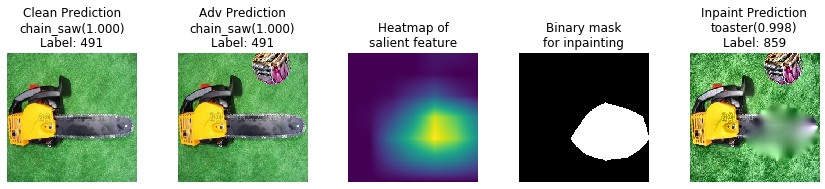

Clean accuracy: 100.00%
Patch success accuracy: 50.00%
Inpainting Accuracy: 0.00%


'img_per_class=100'

In [10]:
id_test.set_params(activation_fntf_act.relu, technique='adaptive_hist_biharmonic_inpaint', bin_thresh=0.7)
id_test.generate_inpaint()

# for i in range(id_test.batch_size):
#     id_test.plot_data(i)
id_test.plot_data(1)

id_test.defense_accuracy()

# base inpainting

### Adversarial

In [ ]:
# # AF: relu, BT: 0.7

# os.chdir(ROOT_DIR)

# id_test = inpaint_defense(activation_fn=tf_act.relu, bin_thresh=0.7, dset_type='adversarial')
# id_test.load_dataset('100class_filtered', img_per_class=100)

# id_test.generate_inpaint()

# # for i in range(id_test.batch_size):
# #     id_test.plot_data(i)
# id_test.plot_data(1)

# id_test.defense_accuracy()

In [ ]:
# # AF: tanh, BT: 0.7

# os.chdir(ROOT_DIR)

# id_test = inpaint_defense(activation_fn=tf_act.tanh, bin_thresh=0.7, dset_type='adversarial')
# id_test.load_dataset('100class_filtered', img_per_class=100)

# id_test.generate_inpaint()

# # for i in range(id_test.batch_size):
# #     id_test.plot_data(i)
# id_test.plot_data(1)

# id_test.defense_accuracy()

In [ ]:
# # AF: linear, BT: 0.7

# os.chdir(ROOT_DIR)

# id_test = inpaint_defense(activation_fn=tf_act.linear, bin_thresh=0.7, dset_type='adversarial')
# id_test.load_dataset('100class_filtered', img_per_class=100)

# id_test.generate_inpaint()

# # for i in range(id_test.batch_size):
# #     id_test.plot_data(i)
# id_test.plot_data(1)

# id_test.defense_accuracy()

### Benign

In [ ]:
# # AF: relu, BT: 0.7

# os.chdir(ROOT_DIR)

# id_test = inpaint_defense(activation_fn=tf_act.relu, bin_thresh=0.7, dset_type='benign')
# id_test.load_dataset('100class_filtered_benign', img_per_class=100)

# id_test.generate_inpaint()

# # for i in range(id_test.batch_size):
# #     id_test.plot_data(i)
# id_test.plot_data(1)

# id_test.defense_accuracy()

In [ ]:
# # AF: tanh, BT: 0.7

# os.chdir(ROOT_DIR)

# id_test = inpaint_defense(activation_fn=tf_act.tanh, bin_thresh=0.7, dset_type='benign')
# id_test.load_dataset('100class_filtered_benign', img_per_class=100)

# id_test.generate_inpaint()

# # for i in range(id_test.batch_size):
# #     id_test.plot_data(i)
# id_test.plot_data(1)

# id_test.defense_accuracy()

In [ ]:
# # AF: linear, BT: 0.7

# os.chdir(ROOT_DIR)

# id_test = inpaint_defense(activation_fn=tf_act.linear, bin_thresh=0.7, dset_type='benign')
# id_test.load_dataset('100class_filtered_benign', img_per_class=100)

# id_test.generate_inpaint()

# # for i in range(id_test.batch_size):
# #     id_test.plot_data(i)
# id_test.plot_data(1)

# id_test.defense_accuracy()

# adaptive_hist

### Adversarial

In [ ]:
id_test = inpaint_defense(activation_fn=tf_act.relu, bin_thresh=0.7, dset_type='adversarial')
id_test.load_dataset('100class_filtered', img_per_class=100)

Found 3187 files belonging to 100 classes.
Found 3187 files belonging to 100 classes.


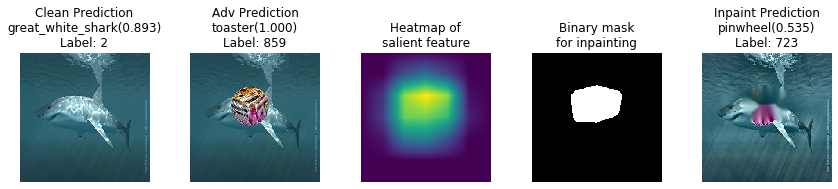

Clean accuracy: 97.49%
Patch success accuracy: 99.91%
Inpainting Accuracy: 69.28%


In [11]:
# AF: relu, BT: 0.7

id_test.set_params(activation_fntf_act.relu, technique='adaptive_hist', bin_thresh=0.7)
id_test.generate_inpaint()

# for i in range(id_test.batch_size):
#     id_test.plot_data(i)
id_test.plot_data(1)

id_test.defense_accuracy()

Found 3187 files belonging to 100 classes.
Found 3187 files belonging to 100 classes.


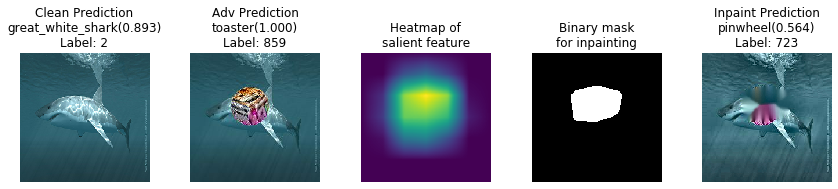

Clean accuracy: 97.49%
Patch success accuracy: 99.91%
Inpainting Accuracy: 69.03%


In [12]:
# AF: tanh, BT: 0.7

id_test.set_params(activation_fntf_act.tanh, technique='adaptive_hist', bin_thresh=0.7)
id_test.generate_inpaint()

# for i in range(id_test.batch_size):
#     id_test.plot_data(i)
id_test.plot_data(1)

id_test.defense_accuracy()

Found 3187 files belonging to 100 classes.
Found 3187 files belonging to 100 classes.


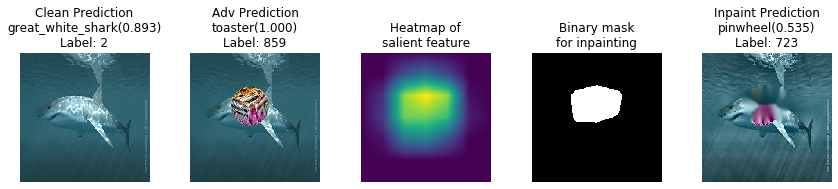

Clean accuracy: 97.49%
Patch success accuracy: 99.91%
Inpainting Accuracy: 69.28%


In [13]:
# AF: linear, BT: 0.7

id_test.set_params(activation_fntf_act.linear, technique='adaptive_hist', bin_thresh=0.7)
id_test.generate_inpaint()

# for i in range(id_test.batch_size):
#     id_test.plot_data(i)
id_test.plot_data(1)

id_test.defense_accuracy()

### Benign

In [ ]:
id_test = inpaint_defense(activation_fn=tf_act.relu, bin_thresh=0.7, dset_type='benign')
id_test.load_dataset('100class_filtered_benign', img_per_class=100)

In [ ]:
# AF: relu, BT: 0.7

id_test.set_params(activation_fntf_act.relu, technique='adaptive_hist', bin_thresh=0.7, dset_type='benign')
id_test.generate_inpaint()

# for i in range(id_test.batch_size):
#     id_test.plot_data(i)
id_test.plot_data(1)

id_test.defense_accuracy()

Found 3722 files belonging to 100 classes.
Found 343 files belonging to 100 classes.


In [ ]:
# AF: tanh, BT: 0.7

id_test.set_params(activation_fntf_act.tanh, technique='adaptive_hist', bin_thresh=0.7, dset_type='benign')
id_test.generate_inpaint()

# for i in range(id_test.batch_size):
#     id_test.plot_data(i)
id_test.plot_data(1)

id_test.defense_accuracy()

In [ ]:
# AF: linear, BT: 0.7

id_test.set_params(activation_fntf_act.linear, technique='adaptive_hist', bin_thresh=0.7, dset_type='benign')
id_test.generate_inpaint()

# for i in range(id_test.batch_size):
#     id_test.plot_data(i)
id_test.plot_data(1)

id_test.defense_accuracy()

# biharmonic_inpaint + adaptive_hist

### Adversarial

In [ ]:
id_test = inpaint_defense(activation_fn=tf_act.relu, bin_thresh=0.7, dset_type='adversarial')
id_test.load_dataset('100class_filtered', img_per_class=100)

In [ ]:
# AF: relu, BT: 0.7

id_test.set_params(activation_fntf_act.relu, technique='adaptive_hist_biharmonic_inpaint', bin_thresh=0.7)
id_test.generate_inpaint()

# for i in range(id_test.batch_size):
#     id_test.plot_data(i)
id_test.plot_data(1)

id_test.defense_accuracy()

In [ ]:
# AF: tanh, BT: 0.7

id_test.set_params(activation_fntf_act.tanh, technique='adaptive_hist_biharmonic_inpaint', bin_thresh=0.7)
id_test.generate_inpaint()

# for i in range(id_test.batch_size):
#     id_test.plot_data(i)
id_test.plot_data(1)

id_test.defense_accuracy()

In [ ]:
# AF: linear, BT: 0.7

id_test.set_params(activation_fntf_act.linear, technique='adaptive_hist_biharmonic_inpaint', bin_thresh=0.7)
id_test.generate_inpaint()

# for i in range(id_test.batch_size):
#     id_test.plot_data(i)
id_test.plot_data(1)

id_test.defense_accuracy()

### Benign

In [ ]:
id_test = inpaint_defense(activation_fn=tf_act.relu, bin_thresh=0.7, dset_type='benign')
id_test.load_dataset('100class_filtered_benign', img_per_class=100)

In [ ]:
# AF: relu, BT: 0.7

id_test.set_params(activation_fntf_act.relu, technique='adaptive_hist_biharmonic_inpaint',
                   bin_thresh=0.7, dset_type='benign')
id_test.generate_inpaint()

# for i in range(id_test.batch_size):
#     id_test.plot_data(i)
id_test.plot_data(1)

id_test.defense_accuracy()

In [ ]:
# AF: tanh, BT: 0.7

id_test.set_params(activation_fntf_act.tanh, technique='adaptive_hist_biharmonic_inpaint',
                   bin_thresh=0.7, dset_type='benign')
id_test.generate_inpaint()

# for i in range(id_test.batch_size):
#     id_test.plot_data(i)
id_test.plot_data(1)

id_test.defense_accuracy()

In [ ]:
# AF: linear, BT: 0.7

id_test.set_params(activation_fntf_act.linear, technique='adaptive_hist_biharmonic_inpaint',
                   bin_thresh=0.7, dset_type='benign')
id_test.generate_inpaint()

# for i in range(id_test.batch_size):
#     id_test.plot_data(i)
id_test.plot_data(1)

id_test.defense_accuracy()

# NEW CODE FROM HERE Navier_Stokes

# Navier_Stokes

### Adversarial

In [ ]:
id_test = inpaint_defense(activation_fn=tf_act.relu, bin_thresh=0.7, dset_type='adversarial')
id_test.load_dataset('100class_filtered', img_per_class=100)

In [ ]:
# AF: relu, BT: 0.7

id_test.set_params(activation_fntf_act.relu, technique='Navier_Stokes', bin_thresh=0.7)
id_test.generate_inpaint()

# for i in range(id_test.batch_size):
#     id_test.plot_data(i)
id_test.plot_data(1)

id_test.defense_accuracy()

In [4]:
# AF: tanh, BT: 0.7

id_test.set_params(activation_fntf_act.tanh, technique='Navier_Stokes', bin_thresh=0.7)
id_test.generate_inpaint()

# for i in range(id_test.batch_size):
#     id_test.plot_data(i)
id_test.plot_data(1)

id_test.defense_accuracy()

NameError: name 'id_test' is not defined

In [ ]:
# AF: linear, BT: 0.7

id_test.set_params(activation_fntf_act.linear, technique='Navier_Stokes', bin_thresh=0.7)
id_test.generate_inpaint()

# for i in range(id_test.batch_size):
#     id_test.plot_data(i)
id_test.plot_data(1)

id_test.defense_accuracy()

### Benign

In [ ]:
id_test = inpaint_defense(activation_fn=tf_act.relu, bin_thresh=0.7, dset_type='benign')
id_test.load_dataset('100class_filtered_benign', img_per_class=100)

In [ ]:
# AF: relu, BT: 0.7

id_test.set_params(activation_fntf_act.relu, technique='Navier_Stokes', bin_thresh=0.7, dset_type='benign')
id_test.generate_inpaint()

# for i in range(id_test.batch_size):
#     id_test.plot_data(i)
id_test.plot_data(1)

id_test.defense_accuracy()

In [ ]:
# AF: tanh, BT: 0.7

id_test.set_params(activation_fntf_act.tanh, technique='Navier_Stokes', bin_thresh=0.7, dset_type='benign')
id_test.generate_inpaint()

# for i in range(id_test.batch_size):
#     id_test.plot_data(i)
id_test.plot_data(1)

id_test.defense_accuracy()

In [ ]:
# AF: linear, BT: 0.7

id_test.set_params(activation_fntf_act.linear, technique='Navier_Stokes', bin_thresh=0.7, dset_type='benign')
id_test.generate_inpaint()

# for i in range(id_test.batch_size):
#     id_test.plot_data(i)v
id_test.plot_data(1)

id_test.defense_accuracy()

# FSR_BEST

### Adversarial

In [ ]:
id_test = inpaint_defense(activation_fn=tf_act.relu, bin_thresh=0.7, dset_type='adversarial')
id_test.load_dataset('100class_filtered', img_per_class=100)

In [ ]:
# AF: relu, BT: 0.7

id_test.set_params(activation_fntf_act.relu, technique='FSR_BEST', bin_thresh=0.7)
id_test.generate_inpaint()

# for i in range(id_test.batch_size):
#     id_test.plot_data(i)
id_test.plot_data(1)

id_test.defense_accuracy()

In [ ]:
# AF: tanh, BT: 0.7

id_test.set_params(activation_fntf_act.tanh, technique='FSR_BEST', bin_thresh=0.7)
id_test.generate_inpaint()

# for i in range(id_test.batch_size):
#     id_test.plot_data(i)
id_test.plot_data(1)

id_test.defense_accuracy()

In [ ]:
# AF: linear, BT: 0.7

id_test.set_params(activation_fntf_act.linear, technique='FSR_BEST', bin_thresh=0.7)
id_test.generate_inpaint()

# for i in range(id_test.batch_size):
#     id_test.plot_data(i)
id_test.plot_data(1)

id_test.defense_accuracy()

### Benign

In [ ]:
id_test = inpaint_defense(activation_fn=tf_act.relu, bin_thresh=0.7, dset_type='benign')
id_test.load_dataset('100class_filtered_benign', img_per_class=100)

In [ ]:
# AF: relu, BT: 0.7

id_test.set_params(activation_fntf_act.relu, technique='FSR_BEST',
                   bin_thresh=0.7, dset_type='benign')
id_test.generate_inpaint()

# for i in range(id_test.batch_size):
#     id_test.plot_data(i)
id_test.plot_data(1)

id_test.defense_accuracy()

In [ ]:
# AF: tanh, BT: 0.7

id_test.set_params(activation_fntf_act.tanh, technique='FSR_BEST',
                   bin_thresh=0.7, dset_type='benign')
id_test.generate_inpaint()

# for i in range(id_test.batch_size):
#     id_test.plot_data(i)
id_test.plot_data(1)

id_test.defense_accuracy()

In [ ]:
# AF: linear, BT: 0.7

id_test.set_params(activation_fntf_act.linear, technique='FSR_BEST',
                   bin_thresh=0.7, dset_type='benign')
id_test.generate_inpaint()

# for i in range(id_test.batch_size):
#     id_test.plot_data(i)v
id_test.plot_data(1)

id_test.defense_accuracy()

# FSR_FAST

### Adversarial

In [ ]:
id_test = inpaint_defense(activation_fn=tf_act.relu, bin_thresh=0.7, dset_type='adversarial')
id_test.load_dataset('100class_filtered', img_per_class=100)

In [ ]:
# AF: relu, BT: 0.7

id_test.set_params(activation_fntf_act.relu, technique='FSR_FAST', bin_thresh=0.7)
id_test.generate_inpaint()

# for i in range(id_test.batch_size):
#     id_test.plot_data(i)
id_test.plot_data(1)

id_test.defense_accuracy()

In [ ]:
# AF: tanh, BT: 0.7

id_test.set_params(activation_fntf_act.tanh, technique='FSR_FAST', bin_thresh=0.7)
id_test.generate_inpaint()

# for i in range(id_test.batch_size):
#     id_test.plot_data(i)
id_test.plot_data(1)

id_test.defense_accuracy()

In [ ]:
# AF: linear, BT: 0.7

id_test.set_params(activation_fntf_act.linear, technique='FSR_FAST', bin_thresh=0.7)
id_test.generate_inpaint()

# for i in range(id_test.batch_size):
#     id_test.plot_data(i)
id_test.plot_data(1)

id_test.defense_accuracy()

### Benign

In [ ]:
id_test = inpaint_defense(activation_fn=tf_act.relu, bin_thresh=0.7, dset_type='benign')
id_test.load_dataset('100class_filtered_benign', img_per_class=100)

In [ ]:
# AF: relu, BT: 0.7

id_test.set_params(activation_fntf_act.relu, technique='FSR_FAST',
                   bin_thresh=0.7, dset_type='benign')
id_test.generate_inpaint()

# for i in range(id_test.batch_size):
#     id_test.plot_data(i)
id_test.plot_data(1)

id_test.defense_accuracy()

In [ ]:
# AF: tanh, BT: 0.7

id_test.set_params(activation_fntf_act.tanh, technique='FSR_FAST',
                   bin_thresh=0.7, dset_type='benign')
id_test.generate_inpaint()

# for i in range(id_test.batch_size):
#     id_test.plot_data(i)
id_test.plot_data(1)

id_test.defense_accuracy()

In [ ]:
# AF: linear, BT: 0.7

id_test.set_params(activation_fntf_act.linear, technique='FSR_FAST',
                   bin_thresh=0.7, dset_type='benign')
id_test.generate_inpaint()

# for i in range(id_test.batch_size):
#     id_test.plot_data(i)v
id_test.plot_data(1)

id_test.defense_accuracy()